# SAE IA

### 1 - Base d'apprentissage

1. Faire une vidéo de chaque figurine de plusieurs minutes

- Le fond doit être exactement le même pour les deux figurines
- Eviter de mettre le même fond que les autres étudiants

2. Convertir la video en images, par exemple avec (ffmpeg)[https://ffmpeg.org] :

```ffmpeg -i obelix.MOV -r 10    -vf scale=150:150 obelix/obelix%03d.jpg```

avec :
   - ``obelix.MOV`` : le fichier video
   - ``10`` : la fréquence pour récupérer une image
   - ``150:150``la taille de l'image
   - ``obelix/obelix%03d.jpg``la forme du fichier image en sortie

![](https://gitlab.inria.fr/Seshat/deepAsterix/-/raw/master/images/dossiers.jpg)

La vidéo doit comprendre des rotations et translations.

3. Ajouter d'autres images trouvées sur internet (bande dessinée, images 3D, films, costumes, etc.) ou généré à partir de webGL avec [https://members.loria.fr/PFVillard/files/asterix/asterix.html](https://members.loria.fr/PFVillard/files/asterix/asterix.html)


4. Faire un dossier pour **Obelix** et un dossier pour **Asterix**

**Question 4.1** Afficher 20 exemples d'images assez différentes pour Asterix et Obelix sous forme de tableau

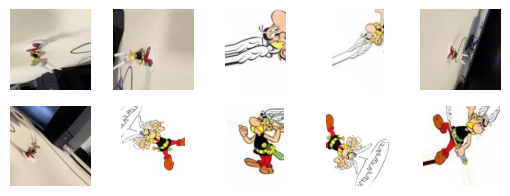

In [24]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def loadImages(path):
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        img = Image.open(path + image)
        loadedImages.append(img)

    return loadedImages

path = "./Asterix/"
# your images in an array
imgsAsterix = loadImages(path)
random.shuffle(imgsAsterix)

# plot 10 images
i = 1
for img in  imgsAsterix[:10]:
    plt.subplot(4,5,i)
    plt.imshow(img)
    plt.axis('off')
    i += 1


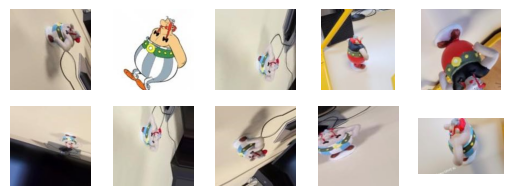

In [25]:
# same for ./Obelix
path = "./Obelix/"
# your images in an array
imgsObelix = loadImages(path)
random.shuffle(imgsObelix)


# plot 10 images
i = 1
for img in  imgsObelix[:10] :
    plt.subplot(4,5,i)
    plt.imshow(img)
    plt.axis('off')
    i += 1

### 2 - Architecture du réseau de neurone et apprentissage

En s'inspirant de l'exercice avec les chats et les chiens :
1. Implémenter une architecture pour détecter automatiquement si une image représente Asterix ou Obelix
   - charger les images en divisant **données d'entraineemnt** et **données d'apprentissage**. Pour plus d'information sur la méthode `image_dataset_from_directory`, voir la [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)
   - utiliser une architecture du type CNN
2. Effectuer l'apprentissage en essayant plusieurs hyperparamètres
3. Enregistrer le modèle appris au format `h5`

**Question 4.2** Mettre le code correspondant aux questions ci-dessus.

In [26]:
from PIL import Image
def loadImages(path):
    imagesList = os.listdir(path)
    loadedImages = []
    for image in imagesList:
        # if the image is not in RGB format, convert it
        img = Image.open(path + image)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        loadedImages.append(img)

    return loadedImages


In [27]:
augment = False

In [28]:
import random
import os
import numpy as np
import tensorflow as tf
# create directories if they don't exist
if not os.path.exists('./data'):
    os.mkdir('./data')
if not os.path.exists('./data/train'):
    os.mkdir('./data/train')
if not os.path.exists('./data/validation'):
    os.mkdir('./data/validation')
if not os.path.exists('./data/train/Asterix'):
    os.mkdir('./data/train/Asterix')
if not os.path.exists('./data/train/Obelix'):
    os.mkdir('./data/train/Obelix')
if not os.path.exists('./data/validation/Asterix'):
    os.mkdir('./data/validation/Asterix')
if not os.path.exists('./data/validation/Obelix'):
    os.mkdir('./data/validation/Obelix')
imgsAsterix = loadImages("./Asterix/")
imgsObelix = loadImages("./Obelix/")
if augment:
    # use keras to make data augmentation
    from keras.preprocessing.image import ImageDataGenerator, img_to_array
    datagen = ImageDataGenerator(
            rotation_range=360,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            fill_mode='nearest')

    # augment data
    for img in imgsAsterix:
        try :
            if "augmented" in img.filename:
                break # all images are already been modified
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in datagen.flow(x, batch_size=1,
                                    save_to_dir='./Asterix/', save_prefix='augmented', save_format='jpg'):
                i += 1
                if i > 20:
                    break  # otherwise the generator would loop indefinitely
        except:
            print("error")
    imgsAsterix = loadImages("./Asterix/")

    for img in imgsObelix:
        if "augmented" in img.filename:
            break # all images are already been modified
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagen.flow(x, batch_size=1,
                                save_to_dir='./Obelix/', save_prefix='augmented', save_format='jpg'):
            i += 1
            if i > 20:
                break  # otherwise the generator would loop indefinitely

    imgsObelix = loadImages("./Obelix/")
random.shuffle(imgsAsterix)
random.shuffle(imgsObelix)
# if ./data/train/Asterix is empty , fill it with 80% of imgsAsterix
if not os.listdir('./data/train/Asterix'):
    # take 80% of asterixIndex
    for i in range(int(len(imgsAsterix)*0.8)):
        imgsAsterix[i].save('./data/train/Asterix/'+str(i)+'.jpg')
print("There is " + str(len(imgsAsterix)) + " images of Asterix")
# if ./data/train/Obelix is empty , fill it with 80% of imgsObelix
if not os.listdir('./data/train/Obelix'):
    # take 80% of obelixIndex
    for i in range(int(len(imgsObelix)*0.8)):
        imgsObelix[i].save('./data/train/Obelix/'+str(i)+'.jpg')
print("There is " + str(len(imgsObelix)) + " images of Obelix")
# if ./data/validation/Asterix is empty , fill it with 20% of imgsAsterix
if not os.listdir('./data/validation/Asterix'):
    for i in range(int(len(imgsAsterix)*0.8),len(imgsAsterix)):
        imgsAsterix[i].save('./data/validation/Asterix/'+str(i)+'.jpg')
# if ./data/validation/Obelix is empty , fill it with 20% of imgsObelix
if not os.listdir('./data/validation/Obelix'):
    for i in range(int(len(imgsObelix)*0.8),len(imgsObelix)):
        imgsObelix[i].save('./data/validation/Obelix/'+str(i)+'.jpg')

There is 896 images of Asterix
There is 924 images of Obelix


**Question 4.3** Mettre toutes les courbes d'apprentissages issues de tous vos entraînement, par exemple, sous forme d'images. 

In [22]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        #strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
        #print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

[]


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a dataset using image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './data/train',
    labels="inferred",
    label_mode="int", # categorical, binary
    class_names=["Asterix","Obelix"],
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './data/train',
    labels="inferred",
    label_mode="int", # categorical, binary
    class_names=["Asterix","Obelix"],
    color_mode="rgb",
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
)


# create model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# start training

model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
)

# save model

model.save_weights('modelAsterixObelix.h5')


Found 1455 files belonging to 2 classes.
Using 1164 files for training.
Found 1455 files belonging to 2 classes.
Using 291 files for validation.
Epoch 1/50
37/37 [==============================] - 11s 265ms/step - loss: 19.6440 - accuracy: 0.5352 - val_loss: 0.6869 - val_accuracy: 0.5945
Epoch 2/50
37/37 [==============================] - 12s 298ms/step - loss: 1.4811 - accuracy: 0.5911 - val_loss: 0.6516 - val_accuracy: 0.6460
Epoch 3/50
37/37 [==============================] - 11s 291ms/step - loss: 0.7860 - accuracy: 0.6426 - val_loss: 0.5713 - val_accuracy: 0.6186
Epoch 4/50
37/37 [==============================] - 12s 310ms/step - loss: 0.7050 - accuracy: 0.6838 - val_loss: 0.5074 - val_accuracy: 0.7766
Epoch 5/50
37/37 [==============================] - 13s 335ms/step - loss: 0.7000 - accuracy: 0.7723 - val_loss: 0.5693 - val_accuracy: 0.7835
Epoch 6/50
37/37 [==============================] - 14s 346ms/step - loss: 0.6816 - accuracy: 0.7766 - val_loss: 0.4941 - val_accuracy: 0.6

Precision sans internet :




 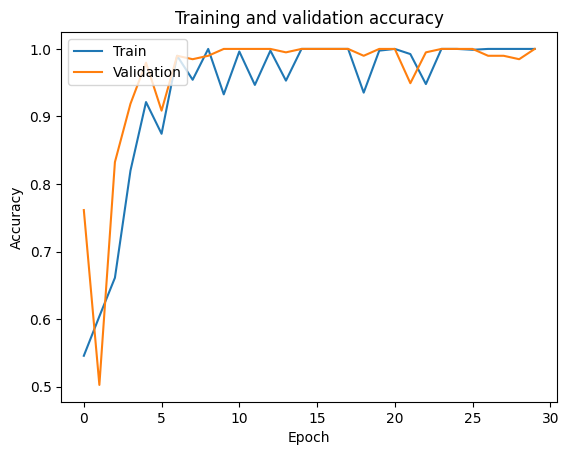

Precision avec internet :



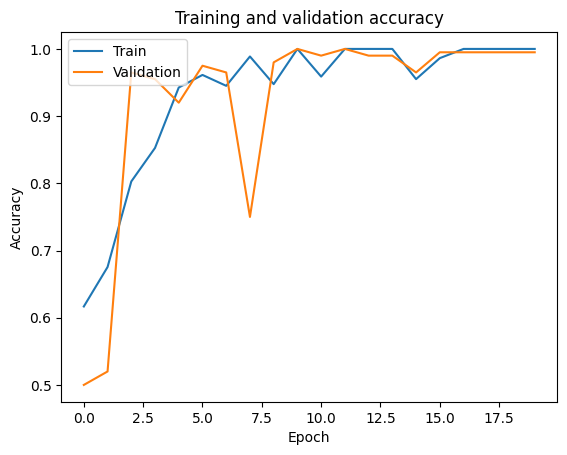

Precision avec des donnée des validation differente et augmentation de donnée: 


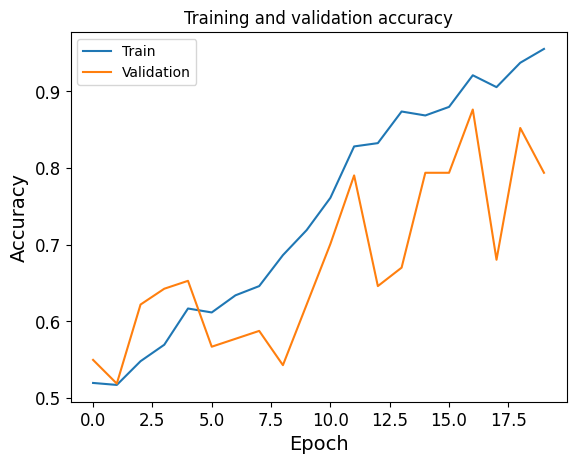


Precision avec des donnée des validation differente et augmentation de donnée , 30 epochs:


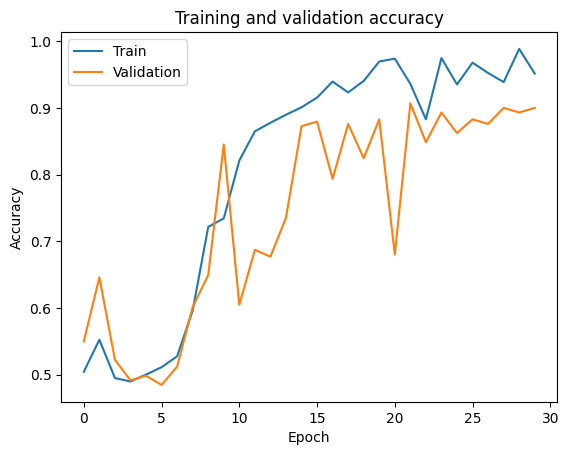


Precision avec des donnée des validation differente et augmentation de donnée , 50 epochs:


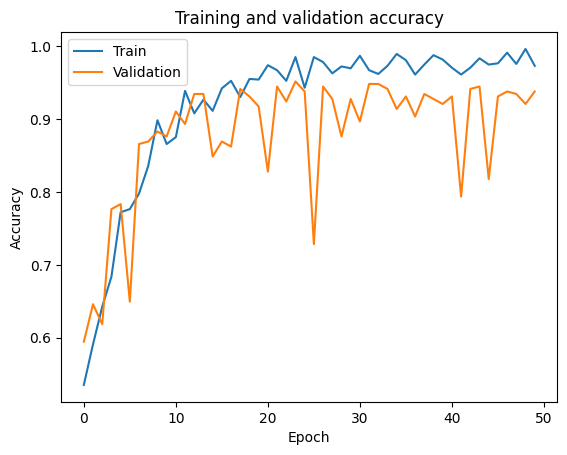

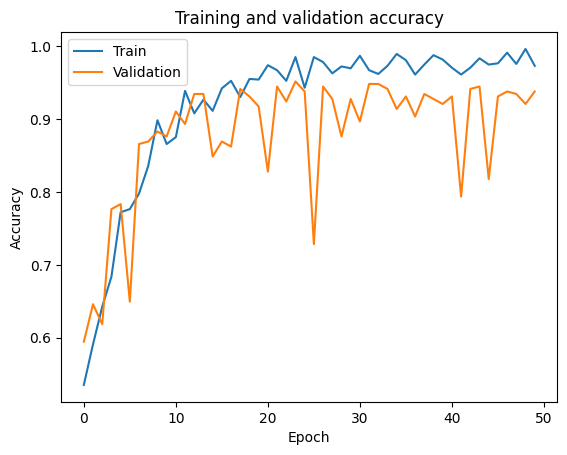

In [24]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


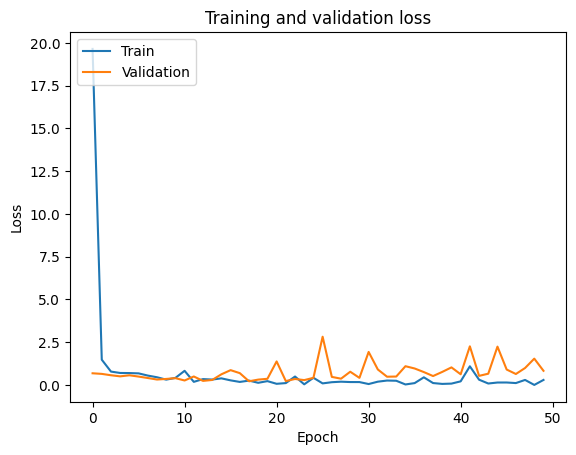

In [20]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
# test model
import numpy as np
from PIL import Image
def predict_class(fichier):
    #import image
    image=plt.imread(fichier)
    plot_image(image)
    #preprocess image
    image=np.array(image)
    image=image.astype("float32")/255
    #predict
    img_size = 150
    inference=model.predict((tf.expand_dims(tf.image.resize(image,(img_size,img_size)),axis=0)))
    predicted_class_indices = np.round(inference)
    return (predicted_class_indices)

def toText(c):
    if c[0][0] == 1:
        return "Asterix"
    else :
        return "Obelix"
